# Short term investment

## MACD 이동 평균 수렴 발산 지수

Moving Average Converagence Divergence

이동 편균선 사이 관계에서 추세 변화를 찾는 지표

이동 편균 선은 과거의 데이터 이므로 실제 추이를 계산하는데 있어서 후행적이다

이를 개선 하기 위해

EMA(Exponential Moving Average) 사용

```
EMA = 종가 x 배율 + EMA (전날) x (1 배율)
```

**MACD**는 단기 평균 - 장기 평균

`MACD` = EMA(12) - EMA(26)

`MACD signal` = EMA(MACD, 9)

`MACD Oscillator`  = `MACD` - `MACD signal`

## MACD 투자 전략


In [166]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import finterstellar as fs
import matplotlib.pyplot as plt

In [167]:
msfTk = yf.Ticker("MSFT")

In [170]:

startDt = datetime(2022,1,1)
endDt = datetime(2023,2,28)
msftDf = msfTk.history(start=startDt, end=endDt)
print(f"msf df's columns : {msftDf.columns}")

msftDf.head(2)

msf df's columns : Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-01-03 00:00:00-05:00,331.406824,334.025658,325.902311,330.813873,28865100,0.0,0.0
2022-01-04 00:00:00-05:00,330.892931,331.258606,322.285355,325.141388,32674300,0.0,0.0


In [ ]:
msftDf.columns[0]

'Open'

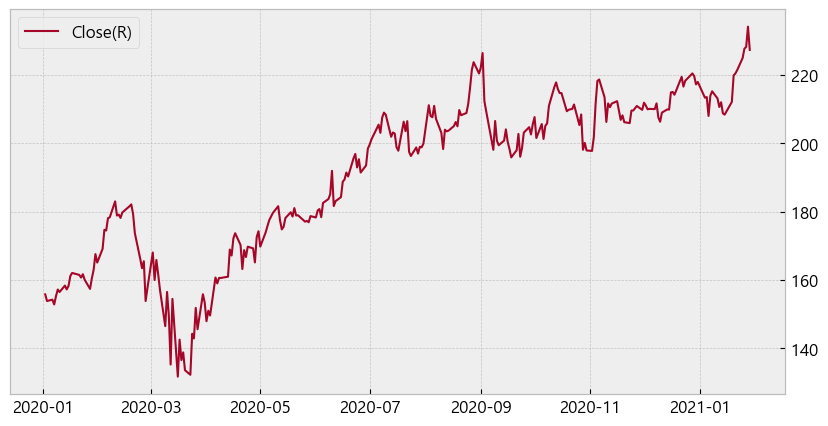

In [ ]:
fs.draw_chart(msftDf, right = 'Close')

In [ ]:
def compareMacdSL(df, short=12, long=26, signal=9):
    """
    Calculate MACD
    df = yf Ticker history
    short = length of short term MACD
    long  = length of long term MACD
    signal = length of MACD signal
    func's return 
        DF of MACD Values
    """
    open = "Close"
    outputDF = df[[open]]
    outputDF['ema_short'] = df[open].ewm(span=short).mean()
    outputDF['ema_long'] = df[open].ewm(span=long).mean()
    outputDF['macd'] = (outputDF['ema_short']-outputDF['ema_long']).round(2)
    outputDF['macd_signal'] = outputDF['macd'].ewm(span=signal).mean().round(2)
    outputDF['macd_oscillator'] = (
        outputDF['macd']-outputDF['macd_signal']).round(2)

    return outputDF[[open, 'macd', 'macd_signal', 'macd_oscillator']]


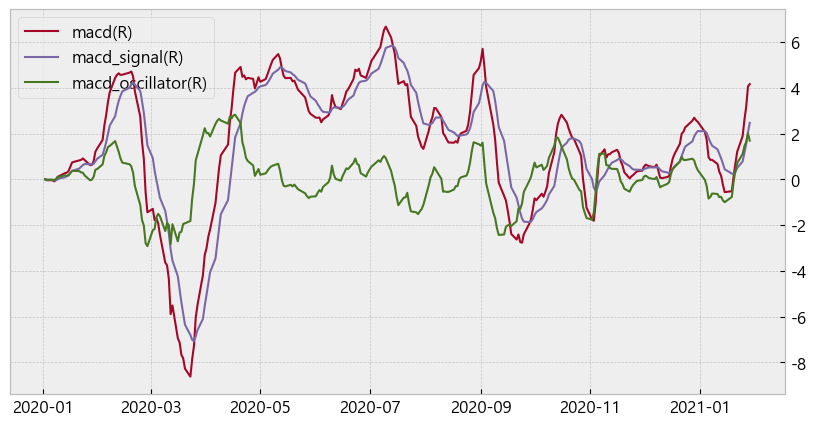

In [ ]:
macdOfMsftDf = compareMacdSL(msftDf)
fs.draw_chart(macdOfMsftDf
, right=['macd', 'macd_signal', 'macd_oscillator'])



In [ ]:
def indicator_to_signal(df, factor, buy, sell):
    outputDf = pd.DataFrame()

    outputDf[factor] = df[factor]
    outputDf['trade'] = np.nan
    if buy >= sell:
        outputDf['trade'] = outputDf['trade'].mask(df[factor] > buy, 'have')
        outputDf['trade'] = outputDf['trade'].mask(df[factor] < sell, 'zero')
    else:
       outputDf['trade'] = outputDf['trade'].mask(df[factor] < buy, 'have')
       outputDf['trade'] = outputDf['trade'].mask(df[factor] > sell, 'zero')
    outputDf['trade'].fillna(method='ffill', inplace=True)
    outputDf['trade'].fillna('zero', inplace=True)
    return outputDf[['trade']]


def getPositionDf(indicatorDf):
    pos = 'position'
    trade = 'position_chart'
    trade = 'trade'

    outputDf = indicatorDf[[trade]]
    outputDf[pos]= ''
    
    outputDf[pos].mask((indicatorDf[trade].shift(1) == 'zero') & (indicatorDf[trade] == 'zero'), 'zero_wait', inplace=True)
    outputDf[pos].mask((indicatorDf[trade].shift(1) == 'zero') & (indicatorDf[trade] == 'have'), 'buy', inplace=True)
    outputDf[pos].mask((indicatorDf[trade].shift(1) == 'have') & (indicatorDf[trade] == 'zero'), 'sell', inplace=True)
    outputDf[pos].mask((indicatorDf[trade].shift(1) == 'have') & ( indicatorDf[trade] == 'have'), 'have_wait', inplace=True)

    outputDf['position_chart'] = 0
    outputDf['position_chart'].mask(
        indicatorDf[trade] == 'have', 1, inplace=True)
    return outputDf


In [ ]:

tradeDf = indicator_to_signal(macdOfMsftDf, factor='macd_oscillator', buy=0, sell = 0)
print(f'trade eval df : {tradeDf.head(10)}')

positionDf = getPositionDf(tradeDf)
positionDf['macd_oscillator'] = macdOfMsftDf['macd_oscillator']
msfEvalDf = pd.merge(macdOfMsftDf, positionDf, how='left', left_index=True, right_index=True )
print(f'msf eval df : {msfEvalDf.head(10)}')

trade eval df :                           trade
Date                           
2020-01-02 00:00:00-05:00  zero
2020-01-03 00:00:00-05:00  zero
2020-01-06 00:00:00-05:00  zero
2020-01-07 00:00:00-05:00  zero
2020-01-08 00:00:00-05:00  have
2020-01-09 00:00:00-05:00  have
2020-01-10 00:00:00-05:00  have
2020-01-13 00:00:00-05:00  have
2020-01-14 00:00:00-05:00  have
2020-01-15 00:00:00-05:00  have
msf eval df :                                 Close  macd  macd_signal  macd_oscillator_x  \
Date                                                                          
2020-01-02 00:00:00-05:00  155.761810  0.00         0.00               0.00   
2020-01-03 00:00:00-05:00  153.822296 -0.04        -0.02              -0.02   
2020-01-06 00:00:00-05:00  154.219925 -0.04        -0.03              -0.01   
2020-01-07 00:00:00-05:00  152.813766 -0.09        -0.05              -0.04   
2020-01-08 00:00:00-05:00  155.247803 -0.02        -0.04               0.02   
2020-01-09 00:00:00-05:00  157.18

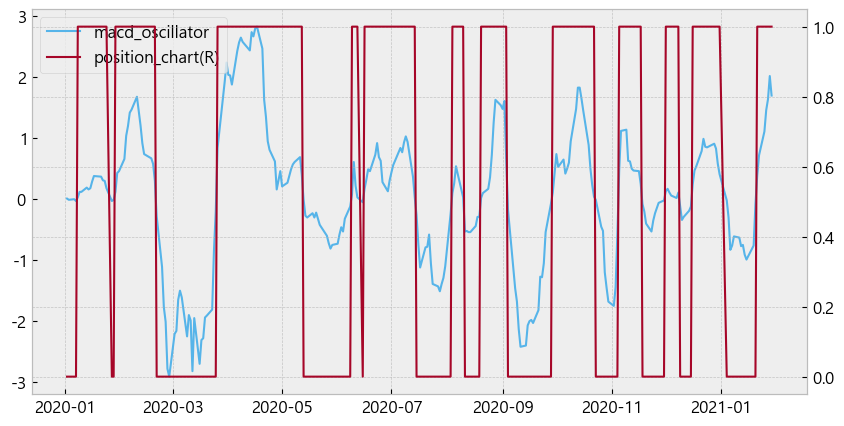

In [ ]:
fs.draw_chart(positionDf, right= "position_chart", left = "macd_oscillator")

In [ ]:
def set_evaluate(df, cost=.001):
    '''
    Calculate daily returns and MDDs of portfolio
    :param df: The dataframe containing trading position
    :param cost: Transaction cost when sell
    :return: Returns, MDD
    '''

    # 0 colum is 'Close'

    df['signal_price'] = np.nan
    df['signal_price'].mask(df['position']=='buy', df.iloc[:,0], inplace=True)
    df['signal_price'].mask(df['position']=='sell', df.iloc[:,0], inplace=True)


    record = df[['position','signal_price']].dropna()
    record['rtn'] = 1
    record['rtn'].mask(record['position']=='sell', (record['signal_price']*(1-cost))/record['signal_price'].shift(1), inplace=True)
    record['acc_rtn'] = record['rtn'].cumprod()


    df['signal_price'].mask(df['position']=='have_wait', df.iloc[:,0], inplace=True)
    df['rtn'] = record['rtn']
    df['rtn'].fillna(1, inplace=True)

    df['daily_rtn'] = 1
    df['daily_rtn'].mask(df['position'] == 'have_wait', df['signal_price'] / df['signal_price'].shift(1), inplace=True)
    df['daily_rtn'].mask(df['position'] == 'sell', (df['signal_price']*(1-cost)) / df['signal_price'].shift(1), inplace=True)
    df['daily_rtn'].fillna(1, inplace=True)
    
    df['acc_rtn'] = df['daily_rtn'].cumprod()
    df['acc_rtn_dp'] = ((df['acc_rtn']-1)*100).round(2)
    df['mdd'] = (df['acc_rtn'] / df['acc_rtn'].cummax()).round(4)
    df['bm_mdd'] = (df.iloc[:, 0] / df.iloc[:, 0].cummax()).round(4)

    print(f'recird : {record.iloc[:10,]}')

    return df

In [ ]:
set_evaluate(msfEvalDf)

recird :                           position  signal_price       rtn   acc_rtn
Date                                                                
2020-01-08 00:00:00-05:00      buy    155.247803  1.000000  1.000000
2020-01-27 00:00:00-05:00     sell    157.371597  1.012666  1.012666
2020-01-29 00:00:00-05:00      buy    162.957397  1.000000  1.012666
2020-02-21 00:00:00-05:00     sell    173.661316  1.064620  1.078105
2020-03-26 00:00:00-04:00      buy    151.801743  1.000000  1.078105
2020-05-13 00:00:00-04:00     sell    174.789322  1.150280  1.240122
2020-06-09 00:00:00-04:00      buy    185.075974  1.000000  1.240122
2020-06-15 00:00:00-04:00     sell    184.237381  0.994473  1.233269
2020-06-16 00:00:00-04:00      buy    188.752151  1.000000  1.233269
2020-07-15 00:00:00-04:00     sell    202.861984  1.073678  1.324134


,Close,macd,macd_signal,macd_oscillator_x,trade,position,position_chart,macd_oscillator_y,signal_price,rtn,daily_rtn,acc_rtn,acc_rtn_dp,mdd,bm_mdd,exs_rtn_daily
Date,,,,,,,,,,,,,,,,
2020-01-08 00:00:00-05:00,155.247803,-0.02,-0.04,0.02,have,buy,1,0.02,155.247803,1.0,1.000000,1.000000,0.00,1.0000,1.0000,-0.000027
2020-01-09 00:00:00-05:00,157.187347,0.11,-0.00,0.11,have,have_wait,1,0.11,157.187347,1.0,1.012493,1.012493,1.25,1.0000,1.0000,-0.000027
2020-01-10 00:00:00-05:00,156.460037,0.15,0.04,0.11,have,have_wait,1,0.11,156.460037,1.0,0.995373,1.007808,0.78,0.9954,0.9954,-0.000027
2020-01-13 00:00:00-05:00,158.341354,0.27,0.09,0.18,have,have_wait,1,0.18,158.341354,1.0,1.012024,1.019927,1.99,1.0000,1.0000,-0.000027
2020-01-14 00:00:00-05:00,157.226166,0.29,0.14,0.15,have,have_wait,1,0.15,157.226166,1.0,0.992957,1.012743,1.27,0.9930,0.9930,-0.000027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25 00:00:00-05:00,224.945526,1.88,0.78,1.10,have,have_wait,1,1.10,224.945526,1.0,1.015844,1.229455,22.95,0.9004,0.9934,-0.000027
2021-01-26 00:00:00-05:00,227.689606,2.59,1.14,1.45,have,have_wait,1,1.45,227.689606,1.0,1.012199,1.244453,24.45,0.9114,1.0000,-0.000027
2021-01-27 00:00:00-05:00,228.248184,3.17,1.54,1.63,have,have_wait,1,1.63,228.248184,1.0,1.002453,1.247506,24.75,0.9136,1.0000,-0.000027


In [ ]:
def performance(df, rf_rate=.01):
    '''
    Calculate additional information of portfolio
    :param df: The dataframe with daily returns
    :param rf_rate: Risk free interest rate
    :return: Number of trades, Number of wins, Hit ratio, Sharpe ratio, ...
    '''
    rst = {}
    rst['no_trades'] = (df['position']=='buy').sum()
    rst['no_win'] = (df['rtn']>1).sum()
    rst['acc_rtn'] = df['acc_rtn'][-1].round(4)
    rst['hit_ratio'] = round((df['rtn']>1).sum() / rst['no_trades'], 4) if rst['no_trades']>0 else 0
    rst['avg_rtn'] = round(df[df['rtn']!=1]['rtn'].mean(), 4)
    rst['period'] = __get_period(df)
    rst['annual_rtn'] = __annualize(rst['acc_rtn'], rst['period'])
    rst['bm_rtn'] = round(df.iloc[-1,0]/df.iloc[0,0], 4)
    rst['sharpe_ratio'] = __get_sharpe_ratio(df, rf_rate)
    rst['mdd'] = df['mdd'].min()
    rst['bm_mdd'] = df['bm_mdd'].min()

    print('CAGR: {:.2%}'.format(rst['annual_rtn'] - 1))
    print('Accumulated return: {:.2%}'.format(rst['acc_rtn'] - 1))
    print('Average return: {:.2%}'.format(rst['avg_rtn'] - 1))
    print('Benchmark return : {:.2%}'.format(rst['bm_rtn']-1))
    print('Number of trades: {}'.format(rst['no_trades']))
    print('Number of win: {}'.format(rst['no_win']))
    print('Hit ratio: {:.2%}'.format(rst['hit_ratio']))
    print('Investment period: {:.1f}yrs'.format(rst['period']/365))
    print('Sharpe ratio: {:.2f}'.format(rst['sharpe_ratio']))
    print('MDD: {:.2%}'.format(rst['mdd']-1))
    print('Benchmark MDD: {:.2%}'.format(rst['bm_mdd']-1))
    return

def __get_period(df):
    df.dropna(inplace=True)
    end_date = df.index[-1]
    start_date = df.index[0]
    days_between = (end_date - start_date).days
    return abs(days_between)


def __annualize(rate, period):
    if period < 360:
        rate = ((rate-1) / period * 365) + 1
    elif period > 365:
        rate = rate ** (365 / period)
    else:
        rate = rate
    return round(rate, 4)


def __get_sharpe_ratio(df, rf_rate):
    '''
    Calculate sharpe ratio
    :param df:
    :param rf_rate:
    :return: Sharpe ratio
    '''
    period = __get_period(df)
    rf_rate_daily = rf_rate / 365 + 1
    df['exs_rtn_daily'] = df['daily_rtn'] - rf_rate_daily
    exs_rtn_annual = (__annualize(df['acc_rtn'][-1], period) - 1) - rf_rate
    exs_rtn_vol_annual = df['exs_rtn_daily'].std() * np.sqrt(365)
    sharpe_ratio = exs_rtn_annual / exs_rtn_vol_annual if exs_rtn_vol_annual>0 else 0
    return round(sharpe_ratio, 4)

In [ ]:
performance(msfEvalDf)

CAGR: 22.73%
Accumulated return: 24.25%
Average return: 1.87%
Benchmark return : 46.43%
Number of trades: 12
Number of win: 5
Hit ratio: 41.67%
Investment period: 1.1yrs
Sharpe ratio: 0.58
MDD: -11.75%
Benchmark MDD: -20.45%


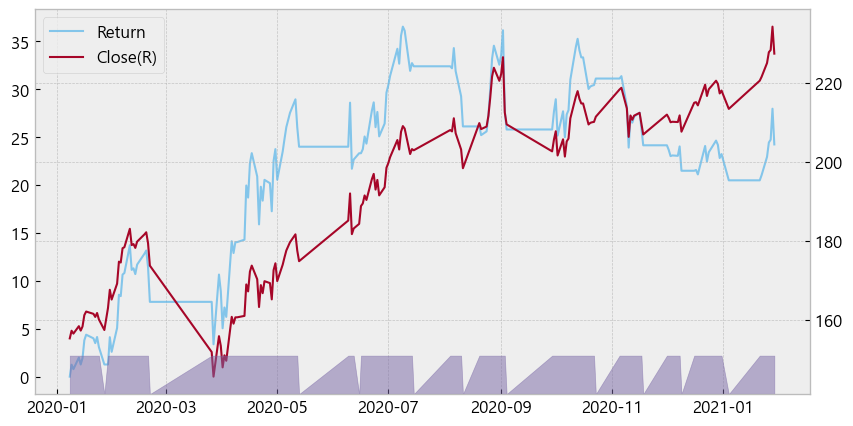

In [ ]:
fs.draw_trade_results(msfEvalDf)